# Word Embeddings Tutorial

## Author: Sriram Srinivasan,  [Contact](mailto:srsrinivasan@google.com)

## Overview
Word embeddings are a mapping from strings to vectors in some vector space. The dimensionality of this vector space is usually fixed ahead of time.

## Learning word embeddings
Typically, word embeddings are learnt through:


*   Supervised learning:

  Example: Predicting house price from the words in the real estate ad. The embedding layer would be one of the layers that maps strings (words in the ad) to a K-dimensional vector and which in-turn interacts with other layers in the model to finally output a price (scalar). The loss function (Regression) guides the learning of embeddings. In practice, one would need lots of labeled data to learn embeddings that generalize to new real estate ads.
  
* Unsupervised Learning:

  This typically involves language modeling tasks, such as predicting the next word given one or few words preceding it. This method is appealing as it requires no labeled data and large corpus of text is easily available from the internet such as News articles, Wikipedia etc.
 
 
## Using Pre-trained Word Embeddings
In most cases, you'd not require to train word embeddings yourself. There exists a number of pre-trained word embeddings on platforms such as [TF-Hub](https://tfhub.dev/) that can be used directly to solve an ML task. These embeddings were trained largely through Unsupervised learning. 

This colab will explore how to use such  pre-trained word embeddings.

In [ ]:
#@title Install TF and TF-Hub.
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn

In [ ]:
#@title Imports.
import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import sklearn
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt


In [ ]:
#@title Plotting and visualization functions.
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(messages_, message_embeddings_):
  plot_similarity(messages_, message_embeddings_, 90)

def plot_pr_curve(y_test_values, pred_y_test):
  precision, recall, thresholds = precision_recall_curve(y_test_values, pred_y_test)
  no_skill = len(y_test_values[y_test_values==1]) / len(y_test_values)
  print("AUC of the model = {}".format(auc(recall, precision)))
  # for idx in range(len(thresholds)):
    # if (thresholds[idx] > 0.4 and thresholds[idx] < 0.5):
    #   print("threshold = {}, precision = {}, recall = {}".format(thresholds[idx], precision[idx], recall[idx]))

  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Majority Class')
  plt.plot(recall, precision, linestyle='--', label='DNN Model')
  plt.title("Average Precission score: %.3f" % average_precision_score(y_test_values, pred_y_test))
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()


## Pre-trained Word Embeddings from TF Hub

For this colab, we'll pick between a couple of TF Hub modules that provide embeddings for a sequence of words (full sentence). These sentence embeddings were learnt using multiple tasks including unsupervised learning (generating surrounding sentences in a passage) as well as supervised learning tasks.
The visualization examples are from the colab accompanying the module page.

In [ ]:
#@title Pick TF Hub Module URL. {run: "auto", vertical-output: true, display-mode: "form"}
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"]

embed = hub.load(module_url)

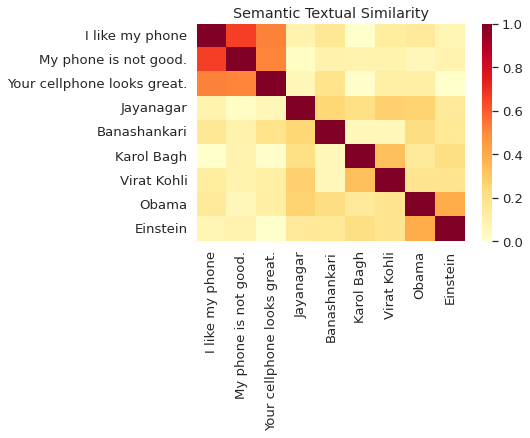

In [ ]:
#@title Visualize Similarity between 2 sentences.
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Places
    "Jayanagar",
    "Banashankari",
    "Karol Bagh",
    
    # Celebrities
    "Virat Kohli",
    "Obama",
    "Einstein", # :-P

]

message_embeddings = embed(messages)
run_and_plot(messages, message_embeddings)

## Using Pre-trained Word Embeddings for Classification tasks

Let's see how well the embeddings from the Universal Sentence Encoder module helps in a classification task. We'll look at the toxic comment classification challenge on Kaggle for this purpose.

Note that this module was never trained on this dataset. So, this would be a test of how well the embeddings transfer to unseen language tasks.

Kaggle challenge: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [ ]:
#@title Import the dataset.
# Original data belongs to https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
! wget https://www.dropbox.com/s/ggl9krhh6dcwhhz/train.csv

--2022-04-20 07:02:22--  https://www.dropbox.com/s/ggl9krhh6dcwhhz/train.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ggl9krhh6dcwhhz/train.csv [following]
--2022-04-20 07:02:22--  https://www.dropbox.com/s/raw/ggl9krhh6dcwhhz/train.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9faf946c2637c0d54602c1376a.dl.dropboxusercontent.com/cd/0/inline/BjuqydAmRlkIortwrrwqLahDXeaeJhie5rAdPNilj0srDUSmyEPeUb6lx1gxxhQ6qN-GwrZqunqb1a052rVP2fmnoascqPCXA2UPXp0AgRs3_QPoJIR1J9qzRqBv2-V5IXqBX_s05-bmQbNlk2Ww7oJ1sR7KYWVOjezdp8Z5BTLAlg/file# [following]
--2022-04-20 07:02:22--  https://uc9faf946c2637c0d54602c1376a.dl.dropboxusercontent.com/cd/0/inline/BjuqydAmRlkIortwrrwqLahDXeaeJhie5rAdPNilj0srDUSmyEPeUb6lx1gxxhQ6qN-GwrZqunqb1

In [ ]:
#@title Check whether the files exist.
! ls -ls train.csv

67192 -rw-r--r-- 1 root root 68802655 Apr 20 07:02 train.csv


### Extract the input and label columns from the dataset.

Input: comment_text
Label: Toxic

In [ ]:
data = pd.read_csv("train.csv")
dataset = data[ ["comment_text", "toxic"] ]

### Generate a train and validation split from the dataset.

In [ ]:
# Train / validation split
dataset = dataset.sample(frac=1)
train_dataset = dataset.head(int(0.8 * len(dataset)))
validation_dataset = dataset.tail(int(0.2 * len(dataset)))

### Visualize the training and validation samples.

In [ ]:
train_dataset.describe()

,toxic
count,127656.000000
mean,0.096408
std,0.295150
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
validation_dataset.describe()

,toxic
count,31914.000000
mean,0.093595
std,0.291269
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
#@title What do the toxic and non-toxic comments look like?
sample_non_toxic = train_dataset[train_dataset.toxic == 0].head(5)
sample_toxic = train_dataset[train_dataset.toxic == 1].head(5)
pd.concat([sample_non_toxic, sample_toxic])

,comment_text,toxic
131186,"Changi Air Base\nHuaiwei, I think we can merge...",0
58823,Multiple versions of #11 released from diversi...,0
99045,Stop it \n\nNo one is block evading. If you re...,0
35987,"""\nLordAmeth once again, many thanks for nomin...",0
32979,You talked and You removed his leanings toward...,0
121246,What the hell is with everybody making Etna ar...,1
147873,Titch why don'tcha shut yer mouth and hang out...,1
6773,"""\nWhat I was saying? You really think that my...",1
50932,"No, you DIDNT. That's obvious. Now if you want...",1
37594,HELLO Liberal MAGGOT Part TWO\nCensorship will...,1


In [ ]:
#@title Setup input numpy arrays.
x_train = train_dataset["comment_text"].values
y_train = np.array(train_dataset["toxic"].values, dtype=np.uint8)
x_validation = validation_dataset["comment_text"].values
y_validation = np.array(validation_dataset["toxic"].values, dtype=np.uint8)

In [ ]:
x_train[:10]

array(["Changi Air Base\nHuaiwei, I think we can merged Changi Air Base (West) back with Changi Air Base and sub section the (West) part in there for better reference, I know it might look a wee bit confusing but once you read the header and sub section, it is pretty clear and precise. Please don't let me down on this.",
       'Multiple versions of #11 released from diversity of sources \n\n http://ia801701.us.archive.org/23/items/Inspire_Magazine/inspire-11.pdf\n http://archive.org/details/Inspire_Magazine\n\nVia Archive.org',
       "Stop it \n\nNo one is block evading. If you remove my edit again, which had an official Tweet confirming such an air date,I'll ask for you to be banned.",
       '"\nLordAmeth once again, many thanks for nominating me. I have a question, though I noticed that the process was ""scheduled to end"" at 16:52 today, and we\'re past that now...what happens next?   "',
       'You talked and You removed his leanings towards Sufism.There is nothing which can be

In [ ]:
y_train[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
#@title A classifier that predicts the majority class.
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras import optimizers
from keras import metrics

input_text = layers.Input(shape=(1,), dtype=tf.string)
pred = layers.Lambda(lambda x: tf.zeros((tf.shape(x)[0], 1), dtype=tf.float32))(input_text)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title Train the model on the dataset.
history = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_validation, y_validation))

3990/3990 [==============================] - 21s 5ms/step - loss: 1.4871 - accuracy: 0.9036 - val_loss: 1.4437 - val_accuracy: 0.9064


## Let's train a simple linear model to identify toxicity.

We'll make use TF Keras API. This allows us to quickly specify the type of model and data to train on and outputs evaluation metrics directly.

In [ ]:
#@title Create a linear model with a head attached to the sentence embedding layer.

def GenerateEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(GenerateEmbedding)(input_text)
pred = layers.Dense(1, activation=tf.nn.sigmoid)(embedding)
model = Model(inputs=[input_text], outputs=pred)
optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_29:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_28:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_27:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_26:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_25:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_24:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_23:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_29:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_28:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_27:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_26:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_25:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_24:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_23:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 lambda_1 (Lambda)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title Train the Linear model on the dataset.
history = model.fit(x_train, y_train, epochs=2, batch_size=128, validation_data=(x_validation, y_validation))
model.save("./linear_model.h5")

Epoch 1/2
998/998 [==============================] - 171s 172ms/step - loss: 0.1786 - accuracy: 0.9397 - val_loss: 0.1670 - val_accuracy: 0.9433
Epoch 2/2
998/998 [==============================] - 179s 180ms/step - loss: 0.1616 - accuracy: 0.9432 - val_loss: 0.1547 - val_accuracy: 0.9456


In [ ]:
#@title Check that the weights have been saved.
!ls -alh | grep linear_model.h5

-rw-r--r-- 1 root root  27K Apr 20 07:18 linear_model.h5


In [ ]:
new_text = ["Totally non toxic sentence !", "What the hell, can't you do anything right?", "Yeah right, this is totally normal."]
new_text = np.array(new_text, dtype=object)[:, np.newaxis]
model.load_weights("./linear_model.h5")
sample_predictions = model.predict(new_text, batch_size=32)
validation_predictions = model.predict(x_validation, batch_size=32)
print("Toxicity for sample inputs = {}".format(sample_predictions))

Toxicity for sample inputs = [[0.3257512 ]
 [0.842052  ]
 [0.28465563]]


AUC of the model = 0.7536538861760743


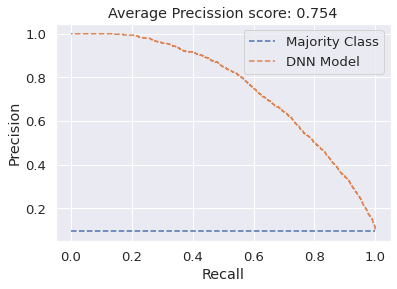

In [ ]:
plot_pr_curve(y_validation, validation_predictions)